# Getting a corpus

In [2]:
from datasets import load_dataset

# This can take a few minutes to load, so grab a coffee or tea while you wait!
raw_datasets = load_dataset("code_search_net", "python")

/home/xuananh/anaconda3/envs/code/lib/python3.8/site-packages/datasets/load.py:1461: FutureWarning: The repository for code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code_search_net
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
raw_datasets["train"]

Dataset({
    features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
    num_rows: 412178
})

In [4]:
len(raw_datasets["train"])

412178

In [5]:
raw_datasets["train"][0].keys()

dict_keys(['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'])

In [6]:
print(raw_datasets["train"][123456]["whole_func_string"])
print(raw_datasets["train"][123456]["whole_func_string"])

def get_new_token(self, netloc):
        """Get a new token from BIG-IP and store it internally.

        Throws relevant exception if it fails to get a new token.

        This method will be called automatically if a request is attempted
        but there is no authentication token, or the authentication token
        is expired.  It is usually not necessary for users to call it, but
        it can be called if it is known that the authentication token has
        been invalidated by other means.
        """
        login_body = {
            'username': self.username,
            'password': self.password,
        }

        if self.auth_provider:
            if self.auth_provider == 'local':
                login_body['loginProviderName'] = 'local'
            elif self.auth_provider == 'tmos':
                login_body['loginProviderName'] = 'tmos'
            elif self.auth_provider not in ['none', 'default']:
                providers = self.get_auth_providers(netloc)
         

In [7]:
DEFAULT_MESSAGE_CALLBACK = lambda x: None
def handle_simple_responses(
      self, timeout_ms=None, info_cb=DEFAULT_MESSAGE_CALLBACK):
    """Accepts normal responses from the device.

    Args:
      timeout_ms: Timeout in milliseconds to wait for each response.
      info_cb: Optional callback for text sent from the bootloader.

    Returns:
      OKAY packet's message.
    """
    return self._accept_responses('OKAY', info_cb, timeout_ms=timeout_ms)

In [8]:
training_corpus = (
    raw_datasets["train"][i : i + 1000]["whole_func_string"]
    for i in range(0, len(raw_datasets["train"]), 1000)
)

In [9]:
gen = (i for i in range(10))
print(list(gen))
print(list(gen))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[]


In [10]:
def get_training_corpus():
    return (
        raw_datasets["train"][i : i + 1000]["whole_func_string"]
        for i in range(0, len(raw_datasets["train"]), 1000)
    )


training_corpus = get_training_corpus()

In [11]:
def get_training_corpus():
    dataset = raw_datasets["train"]
    for start_idx in range(0, len(dataset), 1000):
        samples = dataset[start_idx : start_idx + 1000]
        yield samples["whole_func_string"]

In [12]:
type(training_corpus)

generator

# Building your tokenizer from scratch

To understand how to build your tokenizer from scratch, we have to dive a little bit more in the 🤗 Tokenizers library and the tokenization pipeline. This pipeline takes several steps:  

- **Normalization:** Executes all the initial transformations over the initial input string. For example when you need to lowercase some text, maybe strip it, or even apply one of the common unicode normalization process, you will add a Normalizer.  

- **Pre-tokenization:** In charge of splitting the initial input string. That's the component that decides where and how to pre-segment the origin string. The simplest example would be to simply split on spaces.  

- **Model:** Handles all the sub-token discovery and generation, this is the part that is trainable and really dependent of your input data.

- **Post-Processing:** Provides advanced construction features to be compatible with some of the Transformers-based SoTA models. For instance, for BERT it would wrap the tokenized sentence around [CLS] and [SEP] tokens.


Other directions: 
- **Decoding**: in charge of mapping back a tokenized input to the original string. 

# Huấn luyện một tokenizer mới

In [13]:
from transformers import AutoTokenizer

old_tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [14]:
example = '''def add_numbers(a, b):
    """Add the two numbers `a` and `b`."""
    return a + b'''

tokens = old_tokenizer.tokenize(example)
tokens

['def',
 'Ġadd',
 '_',
 'n',
 'umbers',
 '(',
 'a',
 ',',
 'Ġb',
 '):',
 'Ċ',
 'Ġ',
 'Ġ',
 'Ġ',
 'Ġ"""',
 'Add',
 'Ġthe',
 'Ġtwo',
 'Ġnumbers',
 'Ġ`',
 'a',
 '`',
 'Ġand',
 'Ġ`',
 'b',
 '`',
 '."',
 '""',
 'Ċ',
 'Ġ',
 'Ġ',
 'Ġ',
 'Ġreturn',
 'Ġa',
 'Ġ+',
 'Ġb']

In [15]:
old_tokenizer.is_fast

True

In [16]:
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, 52000)

In [17]:
tokens = tokenizer.tokenize(example)
print(tokens)


['def', 'Ġadd', '_', 'numbers', '(', 'a', ',', 'Ġb', '):', 'ĊĠĠĠ', 'Ġ"""', 'Add', 'Ġthe', 'Ġtwo', 'Ġnumbers', 'Ġ`', 'a', '`', 'Ġand', 'Ġ`', 'b', '`."""', 'ĊĠĠĠ', 'Ġreturn', 'Ġa', 'Ġ+', 'Ġb']


In [18]:
tokenizer.is_fast

True

In [19]:
print(len(tokens))
print(len(old_tokenizer.tokenize(example)))

27
36


In [20]:
example = """class LinearLayer():
    def __init__(self, input_size, output_size):
        self.weight = torch.randn(input_size, output_size)
        self.bias = torch.zeros(output_size)

    def __call__(self, x):
        return x @ self.weights + self.bias
    """
print(tokenizer.tokenize(example))

['class', 'ĠLinear', 'Layer', '():', 'ĊĠĠĠ', 'Ġdef', 'Ġ__', 'init', '__(', 'self', ',', 'Ġinput', '_', 'size', ',', 'Ġoutput', '_', 'size', '):', 'ĊĠĠĠĠĠĠĠ', 'Ġself', '.', 'weight', 'Ġ=', 'Ġtorch', '.', 'randn', '(', 'input', '_', 'size', ',', 'Ġoutput', '_', 'size', ')', 'ĊĠĠĠĠĠĠĠ', 'Ġself', '.', 'bias', 'Ġ=', 'Ġtorch', '.', 'zeros', '(', 'output', '_', 'size', ')', 'ĊĊĠĠĠ', 'Ġdef', 'Ġ__', 'call', '__(', 'self', ',', 'Ġx', '):', 'ĊĠĠĠĠĠĠĠ', 'Ġreturn', 'Ġx', 'Ġ@', 'Ġself', '.', 'weights', 'Ġ+', 'Ġself', '.', 'bias', 'ĊĠĠĠĠ']


# Tokenizer nhanh và chậm

In [21]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
encoding = tokenizer(example)
print(type(encoding))

<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [22]:
tokenizer.is_fast

True

In [23]:
print(encoding.tokens())

['[CLS]', 'My', 'name', 'is', 'S', '##yl', '##va', '##in', 'and', 'I', 'work', 'at', 'Hu', '##gging', 'Face', 'in', 'Brooklyn', '.', '[SEP]']


In [24]:
encoding.word_ids()

[None, 0, 1, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, None]

In [25]:
start, end = encoding.word_to_chars(3)
example[start:end]

'Sylvain'

## Bên trong pipeline token-classification

pipeline là một nhóm các model đã được code sẵn 

In [26]:
from transformers import pipeline

token_classifier = pipeline("token-classification")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

2024-05-17 17:07:12.617401: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 17:07:13.178742: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the chec

[{'entity': 'I-PER',
  'score': 0.99938285,
  'index': 4,
  'word': 'S',
  'start': 11,
  'end': 12},
 {'entity': 'I-PER',
  'score': 0.99815494,
  'index': 5,
  'word': '##yl',
  'start': 12,
  'end': 14},
 {'entity': 'I-PER',
  'score': 0.99590707,
  'index': 6,
  'word': '##va',
  'start': 14,
  'end': 16},
 {'entity': 'I-PER',
  'score': 0.99923277,
  'index': 7,
  'word': '##in',
  'start': 16,
  'end': 18},
 {'entity': 'I-ORG',
  'score': 0.9738931,
  'index': 12,
  'word': 'Hu',
  'start': 33,
  'end': 35},
 {'entity': 'I-ORG',
  'score': 0.976115,
  'index': 13,
  'word': '##gging',
  'start': 35,
  'end': 40},
 {'entity': 'I-ORG',
  'score': 0.9887976,
  'index': 14,
  'word': 'Face',
  'start': 41,
  'end': 45},
 {'entity': 'I-LOC',
  'score': 0.9932106,
  'index': 16,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

thực hiện nhóm chúng lại với nhau 

In [27]:
from transformers import pipeline

token_classifier = pipeline("token-classification", aggregation_strategy="simple")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'entity_group': 'PER',
  'score': 0.9981694,
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.9796019,
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': 0.9932106,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

In [28]:
from transformers import AutoTokenizer, TFAutoModelForTokenClassification

model_checkpoint = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForTokenClassification.from_pretrained(model_checkpoint)

example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
inputs = tokenizer(example, return_tensors="tf")
outputs = model(**inputs)

2024-05-17 17:07:18.188945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 17:07:18.209848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-17 17:07:18.210021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [29]:
print(inputs["input_ids"].shape)
print(outputs.logits.shape)



(1, 19)
(1, 19, 9)


Chúng ta có một lô với 1 chuỗi gồm 19 token và mô hình có 9 nhãn khác nhau, vì vậy đầu ra của mô hình có hình dạng 1 x 19 x 9. Giống như đối với pipeline phân loại văn bản, chúng ta sử dụng hàm softmax để chuyển đổi các logits đó theo xác suất, và chúng ta lấy argmax để nhận dự đoán (lưu ý rằng ta có thể lấy argmax trên logits vì softmax không thay đổi thứ tự):

In [30]:
import tensorflow as tf

probabilities = tf.math.softmax(outputs.logits, axis=-1)[0]
probabilities = probabilities.numpy().tolist()
predictions = tf.math.argmax(outputs.logits, axis=-1)[0]
predictions = predictions.numpy().tolist()
print(predictions)

[0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 6, 6, 6, 0, 8, 0, 0]


In [31]:
model.config.id2label

{0: 'O',
 1: 'B-MISC',
 2: 'I-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-ORG',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'I-LOC'}

ở đây định dạng B-PER chỉ được sử dụng để phân tách 2 từ khác nhau, dòng thứ 2 màu hồng được sử dụng trong hoàn cảnh này (còn để dễ hiểu và phân biệt rõ hơn ta sẽ nhìn vào dòng thứ 3)

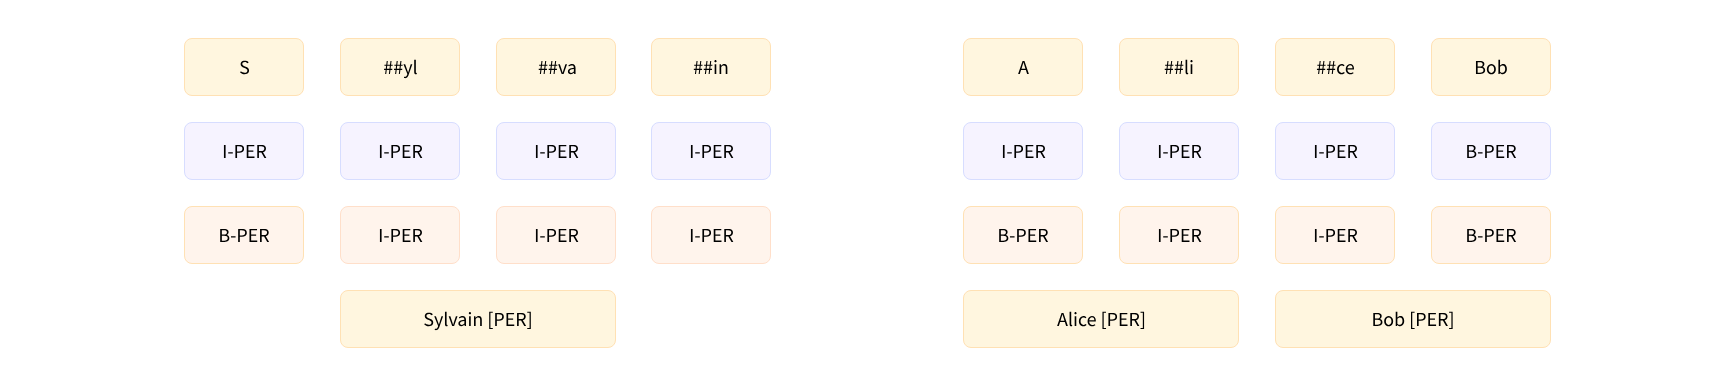

In [32]:
results = []
tokens = inputs.tokens()

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        results.append(
            {"entity": label, "score": probabilities[idx][pred], "word": tokens[idx]}
        )

print(results)

[{'entity': 'I-PER', 'score': 0.9993829727172852, 'word': 'S'}, {'entity': 'I-PER', 'score': 0.998155415058136, 'word': '##yl'}, {'entity': 'I-PER', 'score': 0.995907187461853, 'word': '##va'}, {'entity': 'I-PER', 'score': 0.9992332458496094, 'word': '##in'}, {'entity': 'I-ORG', 'score': 0.9739148616790771, 'word': 'Hu'}, {'entity': 'I-ORG', 'score': 0.976115882396698, 'word': '##gging'}, {'entity': 'I-ORG', 'score': 0.9888299107551575, 'word': 'Face'}, {'entity': 'I-LOC', 'score': 0.9932070374488831, 'word': 'Brooklyn'}]


In [33]:
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
inputs_with_offsets["offset_mapping"]

[(0, 0),
 (0, 2),
 (3, 7),
 (8, 10),
 (11, 12),
 (12, 14),
 (14, 16),
 (16, 18),
 (19, 22),
 (23, 24),
 (25, 29),
 (30, 32),
 (33, 35),
 (35, 40),
 (41, 45),
 (46, 48),
 (49, 57),
 (57, 58),
 (0, 0)]

# Sử dụng pipeline question-answering

In [34]:
from transformers import pipeline

question_answerer = pipeline("question-answering")
context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch, and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'score': 0.9802603125572205,
 'start': 78,
 'end': 106,
 'answer': 'Jax, PyTorch, and TensorFlow'}

In [35]:
long_context = """
🤗 Transformers: State of the Art NLP

🤗 Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction,
question answering, summarization, translation, text generation and more in over 100 languages.
Its aim is to make cutting-edge NLP easier to use for everyone.

🤗 Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets and
then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and
can be modified to enable quick research experiments.

Why should I use transformers?

1. Easy-to-use state-of-the-art models:
  - High performance on NLU and NLG tasks.
  - Low barrier to entry for educators and practitioners.
  - Few user-facing abstractions with just three classes to learn.
  - A unified API for using all our pretrained models.
  - Lower compute costs, smaller carbon footprint:

2. Researchers can share trained models instead of always retraining.
  - Practitioners can reduce compute time and production costs.
  - Dozens of architectures with over 10,000 pretrained models, some in more than 100 languages.

3. Choose the right framework for every part of a model's lifetime:
  - Train state-of-the-art models in 3 lines of code.
  - Move a single model between TF2.0/PyTorch frameworks at will.
  - Seamlessly pick the right framework for training, evaluation and production.

4. Easily customize a model or an example to your needs:
  - We provide examples for each architecture to reproduce the results published by its original authors.
  - Model internals are exposed as consistently as possible.
  - Model files can be used independently of the library for quick experiments.

🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question_answerer(question=question, context=long_context)

{'score': 0.9714871048927307,
 'start': 1892,
 'end': 1919,
 'answer': 'Jax, PyTorch and TensorFlow'}

In [36]:
long_context[1892:1919]

'Jax, PyTorch and TensorFlow'

ta sẽ đi sâu thêm vào mô hình, Sử dụng mô hình cho tác vụ hỏi đáp 

In [37]:
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering

model_checkpoint = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

inputs = tokenizer(question, context, return_tensors="tf") 
outputs = model(**inputs)




All PyTorch model weights were used when initializing TFDistilBertForQuestionAnswering.

All the weights of TFDistilBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


In [38]:
question


'Which deep learning libraries back 🤗 Transformers?'

In [39]:
context

"\n🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch, and TensorFlow — with a seamless integration\nbetween them. It's straightforward to train your models with one before loading them for inference with the other.\n"

In [40]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

(1, 67) (1, 67)


In [41]:
import tensorflow as tf

sequence_ids = inputs.sequence_ids()
# Che tất cả mọi thứ trừ token của ngữ cảnh
mask = [i != 1 for i in sequence_ids]
# Hiển thị token [CLS]
mask[0] = False
mask = tf.constant(mask)[None]

start_logits = tf.where(mask, -10000, start_logits)
end_logits = tf.where(mask, -10000, end_logits)

các bước để xử lý một tokenizer  
<img src="https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter6/tokenization_pipeline.svg" width="50%">

chúng ta sẽ tiến hành qua 4 bước sau:
- normalization   
- pre-tokenization  
- model  
- post-processing  


In [42]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print(type(tokenizer.backend_tokenizer)) 

<class 'tokenizers.Tokenizer'>


Thuộc tính normalizer của đối tượng tokenizer có phương thức normalize_str() mà ta có thể dùng để thấy cách bước chuẩn hoá được thực hiện:

In [43]:
print(tokenizer.backend_tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

hello how are u?


## Pre-tokenization

In [44]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('how', (7, 10)),
 ('are', (11, 14)),
 ('you', (16, 19)),
 ('?', (19, 20))]

In [45]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('Ġhow', (6, 10)),
 ('Ġare', (10, 14)),
 ('Ġ', (14, 15)),
 ('Ġyou', (15, 19)),
 ('?', (19, 20))]

In [46]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('▁Hello,', (0, 6)),
 ('▁how', (7, 10)),
 ('▁are', (11, 14)),
 ('▁you?', (16, 20))]

# Triển khai BPE

In [47]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

Tiếp theo, ta cần tiền tokenize kho ngữ liệu này thành các từ. Vì ta đang sao chép một bản BPE tokenizer (như GPT-2), ta vẫn có thể sử dụng gpt2 tokenize cho bước pre-tokenization:

Copied


In [48]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

Sau đó ta tính tần suất của từng từ trong kho ngữ liệu như khi làm với pre-tokenization:

In [49]:
from collections import defaultdict

word_freqs = defaultdict(int)

for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

print(word_freqs)

defaultdict(<class 'int'>, {'This': 3, 'Ġis': 2, 'Ġthe': 1, 'ĠHugging': 1, 'ĠFace': 1, 'ĠCourse': 1, '.': 4, 'Ġchapter': 1, 'Ġabout': 1, 'Ġtokenization': 1, 'Ġsection': 1, 'Ġshows': 1, 'Ġseveral': 1, 'Ġtokenizer': 1, 'Ġalgorithms': 1, 'Hopefully': 1, ',': 1, 'Ġyou': 1, 'Ġwill': 1, 'Ġbe': 1, 'Ġable': 1, 'Ġto': 1, 'Ġunderstand': 1, 'Ġhow': 1, 'Ġthey': 1, 'Ġare': 1, 'Ġtrained': 1, 'Ġand': 1, 'Ġgenerate': 1, 'Ġtokens': 1})


Tiếp theo chúng ta sẽ tính bộ từ vựng cơ sở từ các kí tự sử dụng trong kho ngữ liệu:

In [50]:
alphabet = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()

print(alphabet)

[',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ']


In [51]:
vocab = ["<|endoftext|>"] + alphabet.copy()

In [52]:
print(vocab)

['<|endoftext|>', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ']


In [53]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    return sum(splits, [])


ĐIỂM MẠNH:
1. tạo được những thành phần từ bị thiếu (sub-word)

ĐIỂM YẾU:
1. không thể tạo được từ mới

# WordPiece tokenization


ĐIỂM MẠNH:
1. so với BPE, tokenizer này học các phần của từ như là token nhanh hơn một chút.



# Unigram tokenization

Tại mỗi bước của quá trình huấn luyện, thuật toán Unigram tính toán sự mất mát trên kho ngữ liệu được cung cấp từ vựng hiện tại. Sau đó, đối với mỗi ký hiệu trong từ vựng, thuật toán sẽ tính toán mức độ tổn thất tổng thể sẽ tăng lên bao nhiêu nếu ký hiệu bị xóa và tìm kiếm các ký hiệu làm tăng nó ít nhất.


nếu chúng ta sử dụng mô hình ngôn ngữ Unigram để tạo văn bản, chúng ta sẽ luôn dự đoán token phổ biến nhất.



-----------
GPT3 dùng word piece

# Xây dựng một WordPiece tokenizer từ đầu


# Thu thập một kho ngữ liệu

#### ta sẽ chia nhỏ thành các batch để không bị over ram memory 

In [54]:
from datasets import load_dataset

dataset = load_dataset("wikitext", name="wikitext-2-raw-v1", split="train")


def get_training_corpus():
    '''
    Hàm trả về các batch với mỗi batch chứa 1000 đoạn văn
    ''' 
    
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]

with open("wikitext-2.txt", "w", encoding="utf-8") as f:
    for i in range(len(dataset)):
        f.write(dataset[i]["text"] + "\n")

In [55]:
with open("wikitext-2.txt", "w", encoding="utf-8") as f:
    for i in range(len(dataset)):
        f.write(dataset[i]["text"] + "\n")

In [56]:
len(dataset[5]['text'])

574

In [130]:
for  i in range(10):
    print(len(dataset[i]['text']))

0
30
0
706
524
574
0
19
0
1221


##### Xây dựng một WordPiece tokenizer từ đầu

In [57]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

ta cần chỉ rõ unknow_token để biết mô hình trả về gì khi gặp token chưa biết. ta cần cài đặt max_input_chars_per_word tương ứng đọ dài tối da cho một từ, từ dài hơn giới hạn này sẽ bị chia nhỏ 

bước đầu chúng ta sẽ đi chuẩn hoá, let's go 

Vì BERT được sử dụng rộng tãi, ta có thể sử dụng BertNormalizer với tuỳ chọn kinh điển để thiết lập cho BERT: lowercase và strip_accents 

In [58]:
from sklearn.feature_extraction.text import strip_accents_ascii

text = "Héllo, hów áre yóu?"
text_without_accents = strip_accents_ascii(text)

print(text_without_accents)

Hello, how are you?


In [59]:
# tokenizer.normalizer = normalizers.Sequence(
#     [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
# )

tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase()]
)

Ta cũng có thể sử dụng chuẩn hoá Unicode NFD Unicode normalizer, vì nếu không chuẩn hoá StripAccents sẽ không nhận diện được những kí tự có dấu và không thể tách nó đúng như ta muốn.



In [60]:
print(tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))
print(tokenizer.normalizer.normalize_str("ok chúng ta nên để như thế này sẽ hay hơn đấy các bạn ạ"))

héllò hôw are ü?
ok chúng ta nên để như thế này sẽ hay hơn đấy các bạn ạ


***đào sâu hơn ***  
Nếu bạn muốn kiểm tra xem hai phiên bản chuẩn hoá trước đó trên cùng mọt chuỗi  ký tự unicode u"\u0085", bạn chắc chắn sẽ nhận thấy rằng hai cách chuẩn hoá này không giống nhau. Để tránh phức tạp hoá phiên bản với normalizers.Sequence quá nhiều, chúng tôi sẽ không abao gồm sự thay thế theo Regex mà BertNormalizer yêu cầu khi tham sỗ clean_text được thiết lập là True -đây cũng là giá trị mặc định. Nhưng đừng lo: có khả năng ta sẽ nhận được kết quả chuẩn hoá giống nhau mà không cần sử dụng BertNormalizer thủ công bằng cách thêm hai normalizers.Replace vào chuỗi chuẩn hoá.




Tiếp theo là bước pre-tokenization. Một lần nữa, ta có BertPreTokenizer được xây dựng sẵn để dùng:

In [61]:
tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()

Hoặc ta có thể xây từ đầu:

In [62]:
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

Lưu ý rằng Whitespace sẽ tách theo dấu cách và các kí tự không phải chữ cái, số, hoặc dấu gạch dưới, nên về mặt kỹ thuật nó sẽ tách theo dấu cách và dấu câu:

In [63]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")

[('Let', (0, 3)),
 ("'", (3, 4)),
 ('s', (4, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre', (14, 17)),
 ('-', (17, 18)),
 ('tokenizer', (18, 27)),
 ('.', (27, 28))]

tách theo dấu cách 

In [64]:
pre_tokenizer = pre_tokenizers.WhitespaceSplit()
pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")

[("Let's", (0, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre-tokenizer.', (14, 28))]

bạn có thể kết hợp các pre-tokenizer với nhau

In [65]:
pre_tokenizer = pre_tokenizers.Sequence(
    [pre_tokenizers.WhitespaceSplit(), pre_tokenizers.Punctuation()]
)
print(pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer."))

pre_tokenizer = pre_tokenizers.Sequence(
    [pre_tokenizers.Punctuation()]
)
print(pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer."))

[('Let', (0, 3)), ("'", (3, 4)), ('s', (4, 5)), ('test', (6, 10)), ('my', (11, 13)), ('pre', (14, 17)), ('-', (17, 18)), ('tokenizer', (18, 27)), ('.', (27, 28))]
[('Let', (0, 3)), ("'", (3, 4)), ('s test my pre', (4, 17)), ('-', (17, 18)), ('tokenizer', (18, 27)), ('.', (27, 28))]


Bước tiếp theo trong pipeline tokenize là đưa đầu vào qua mô hình. Ta đã chỉ định mô hình của mình khi khởi tạo, nhưng ta vẫn cần huấn luyện nó, điều này cần tới WordPieceTrainer.

vấn đề ở đây là khi khởi động một trình huấn luyện trong hugging face thì bạn cần truyền tất cả các ký tự đặc biệt bạn cần khi sử dụng,  nếu không nó sẽ không thêm vào bộ từ vựng, vì chúng không có trong kho ngữ liệu huấn luyện 

Ví dụ, trong BERT, các token đặc biệt bao gồm [CLS], [SEP], và [MASK]. Những token này có ý nghĩa đặc biệt trong mô hình và không nên bị chia nhỏ. Để tránh việc chúng bị chia nhỏ, ta cần thêm chúng vào bộ từ vựng trước khi huấn luyện mô hình.

In [66]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)

Cũng như việc chỉ định vocab_size và special_tokens, ta cần thiết lập min_frequency (số lần một token phải xuất hiện để được thêm vào bộ từ vựng) hoặc thay đổi continuing_subword_prefix (nếu ta muốn sử dụng thứ gì khác ngoài ##). 

Để huấn luyện một mô hình sử dụng trình lặp ta định nghĩa trước đó, ta chỉ cần thực hiện lệnh này:

In [67]:
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

chúng ta cũng có thể sử dụng các tệp văn bản để huấn luyện tokenizer của mình như sau (ta tái khởi tạo mô hình với một WordPiece rỗng):



In [68]:
tokenizer.model = models.WordPiece(unk_token="[UNK]")
tokenizer.train(["wikitext-2.txt"], trainer=trainer)

In [69]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '.']


encoding thu dc là một encoding gồm tất cả các đầu ra cần thiết  của một tokenizer trong tất cả các thông số đa dạng của nó: ids, type_ids, tokens, offsets, attention_mask, special_toekns_mask và overflowing 

hậu xử lý: post-tokenizer 

ta cần thêm token [CLS] token tại đầu và [SEP] ở cuối (hoặc sau mỗi câu nếu ta có cặp câu). Chúng ta sẽ sử dụng `TemplateProcessor` để thực hiện điều này 

In [70]:
cls_token_id = tokenizer.token_to_id("[CLS]")
sep_token_id = tokenizer.token_to_id("[SEP]")
print(cls_token_id, sep_token_id)

2 3


Để viết bản mẫu cho TemplateProcessor, chúng ta phải chỉ định cách xử lý một câu đơn và một cặp câu. Đối với cả hai, chúng tôi viết các token đặc biệt muốn sử dụng; câu đầu tiên (hoặc câu đơn) được biểu thị bằng $A, trong khi câu thứ hai (nếu token một cặp) được biểu thị bằng $B. Đối với mỗi  loại trong số này (token và câu đặc biệt), chúng ta cũng chỉ định loại token ID tương ứng sau hai dấu chấm. 

Do đó, bản mẫu BERT cổ điển được định nghĩa như sau:

In [71]:
tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[CLS]:0 $A:0 [SEP]:0",
    pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
    special_tokens=[("[CLS]", cls_token_id), ("[SEP]", sep_token_id)],
)

lưu ý rằng chúng ta cần truyền vào tất cả các IDs của các ký tự đặc biệt, nên các tokenizer có thể chuyển đổi chúng thành các cặp ID.

Một khi đã thêm vào chúng ta có thể quay lại ví dụ trước đó và sẽ nhận được 

In [72]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['[CLS]', 'let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '.', '[SEP]']


Và trên một cặp câu, chúng ta có thể có được kết quả sau:

In [73]:
encoding = tokenizer.encode("Let's test this tokenizer.." , "on a pair of sentences.")
print(encoding.tokens)
print(encoding.type_ids)

['[CLS]', 'let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '..', '[SEP]', 'on', 'a', 'pair', 'of', 'sentences', '.', '[SEP]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


Chúng ta đã gần như hoàn thành việc xây dựng tokenizer này từ đầu — bước cuối cùng là thêm vào một trình giải mã:

In [74]:
tokenizer.decoder = decoders.WordPiece(prefix="##")

Hãy cũng kiểm thử với encoding:

In [75]:
tokenizer.decode(encoding.ids)

"let ' s test this tokenizer.. on a pair of sentences."

Tuyệt vời! Ta có thể lưu tokenizer của mình vào trong một tệp JSON như dưới đây:

In [76]:
tokenizer.save("tokenizer.json")

Ta sau đó có thể load lại tệp này trong đối tượng Tokenizer với phương thức from_file():

In [77]:
new_tokenizer = Tokenizer.from_file("tokenizer.json")

Để sử dụng tokenizer này trong 🤗 Transformers, chúng ta phải bọc nó trong PreTrainedTokenizerFast.

Chúng ta có thể sử dụng lớp chung hoặc, nếu tokenizer của chúng ta tương ứng với một mô hình hiện có, hãy sử dụng lớp đó (ở đây là BertTokenizerFast). Nếu bạn áp dụng bài học này để xây dựng một tokenizer hoàn toàn mới, bạn sẽ phải sử dụng tùy chọn đầu tiên.



Để bọc tokenizer trong một PreTrainedTokenizerFast, chúng ta có thể chuyển tokenizer mà chúng ta đã xây dựng dưới dạng tokenizer_object hoặc truyền tệp tokenizer chúng ta đã lưu dưới dạng tokenizer_file. Điều quan trọng cần nhớ là chúng ta phải đặt thủ công tất cả các tokenizer đặc biệt , vì lớp đó không thể suy ra từ đối tượng tokenizer nào là tokenizer bị MASK, [CLS], [SEP], và [PAD] ...

In [78]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    # tokenizer_file="tokenizer.json", # Bạn có thể tải từ tệp tokenizer
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

Nếu bạn đang sự dụng một lớp tokenizer đặc biệt (như BertTokenizerFast), bạn chỉ cần chỉ định một token đặc biết khác so với mặc định (ở đây là không xác định, do các thành phần này đã có từ trước).

In [79]:
from transformers import BertTokenizerFast

wrapped_tokenizer = BertTokenizerFast(tokenizer_object=tokenizer)

Bạn có thể sử dụng tokenizer như bất kỳ tokenizer nào khác của hugging face transformers. Bạn có thể lưu nó với phương thức save_pretrained(), hoặc push nó lên Hub với phương thức push_to_hub().

Giờ chúng ta đã thấy cách xây dựng bộ WordPiece tokenizer, hãy làm tương tự đối với BPE tokenizer. Chúng ta sẽ tiến hành nhanh hơn một chút vì bạn đã biết tất cả các bước và chỉ làm nổi bật những điểm khác biệt.

# Xây dựng một BPE tokenizer từ đầu


Giờ hãy cũng nhau xây dựng GPT-2 tokenizer. Giống như BERT tokenizer, chúng ta bắt đầu bằng việc khởi tạo Tokenizer với mô hình BPE:

In [80]:
tokenizer = Tokenizer(models.BPE())

cũng giống như Bert, chúng ta có thể khởi tạo mô hình này với một bộ từ vựng nếu ta đã có (ta sẽ cần truyền vào vocab và merges trong trường hợp này), nhưng vì ta sẽ huấn luyện từ đầu, chúng ta không cần làm vậy. Ta cũng không cần chỉ định unk_token vì GPT-2 sử dụng BPE cấp byte, phương pháp không cần đến nó 

GPT-2 không sử dụng một trình chuẩn hoá, nên ta có thể bỏ qua bước này và đi trực tiếp vào bước pre-tokenization:

In [81]:
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

Tuỳ chọn ByteLevel chúng ta thêm vào ở đây không thêm dấu cách vào đầu của một câu (thường nó là mặc định). Ta có thể nhìn các pre-tokenization từ ví dụ tương tự ở trên:

In [82]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test pre-tokenization!")

[('Let', (0, 3)),
 ("'s", (3, 5)),
 ('Ġtest', (5, 10)),
 ('Ġpre', (10, 14)),
 ('-', (14, 15)),
 ('tokenization', (15, 27)),
 ('!', (27, 28))]

(nhắc lại: Ġ là ký hiệu dấu cách)

Tiếp theo là mô hình mà ta cần huấn luyện. Với GPT-2, token đặc biệt duy nhất cần là token kết thúc văn bản: 

In [83]:
trainer = trainers.BpeTrainer(vocab_size=25000, special_tokens=["<|endoftext|>"])
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

Như với WordPieceTrainer, cũng như vocab_size và special_tokens, ta có thể chỉ định min_frequency nếu muốn, hoặc nếu ta có hậu tố kết thúc từ (như </w>), ta có thể thiết lập nó với end_of_word_suffix.

***tokenizer này cũng có thể được huấn luyện trên các tệp văn bản:***

In [84]:
tokenizer.model = models.BPE()
tokenizer.train(["wikitext-2.txt"], trainer=trainer)


Hãy cũng xem kết quả tokenize trên một văn bản mẫu:

In [85]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['L', 'et', "'", 's', 'Ġtest', 'Ġthis', 'Ġto', 'ken', 'izer', '.']


Ta áp dụng hậu xử lý cấp byte cho GPT-2 tokenizer như sau:

In [86]:
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)

tuỳ chọn trim_offsets = False chỉ cho hậu xử lý biết rằng ta cần bỏ một số offset token bắt đầu với "Ġ": theo cách này, điểm bắt đầu của ofset sẽ trỏ vào vùng không gian phía trước của từ  (vì vùng không gian này về mặt kỹ thuật là một phần của từ). Hãy cùng nhìn xem kết quả với chuỗi văn bản  ta vuewaf mã hoá với 'Ġtest' là token ở chỉ mục 4:

In [101]:
sentence = "Let's test this tokenizer."
encoding = tokenizer.encode(sentence)
start, end = encoding.offsets[4]
sentence[start:end]

' test'

In [102]:
print(encoding.tokens)
len(encoding.tokens)
print(encoding.offsets)
count = 0
for (start, end) in encoding.offsets:
    print(sentence[start:end])
    count += 1
    if count == 10:
        break

['L', 'et', "'", 's', 'Ġtest', 'Ġthis', 'Ġto', 'ken', 'izer', '.']
[(0, 1), (1, 3), (3, 4), (4, 5), (5, 10), (10, 15), (15, 18), (18, 21), (21, 25), (25, 26)]
L
et
'
s
 test
 this
 to
ken
izer
.


cuối cùng,  ta thêm một trình giải mã cấp byte:


In [103]:
tokenizer.decoder = decoders.ByteLevel()


và kiểm tra xem nó hoạt động đúng chưa 

In [104]:
tokenizer.decode(encoding.ids)

"Let's test this tokenizer."

==> nó đã reproduce lại câu ban đầu nên nó đã hoạt động đúng 

Giờ ta đã xong rồi, ta có thể lưu tokenizer như trên, và bao nó lại trong PreTrainedTokenizerFast hoặc GPT2TokenizerFast nếu ta muốn nó trong 🤗 Transformers:

In [108]:
# cách 1 
from transformers import PreTrainedTokenizerFast 
wrapped_tokenizer  = PreTrainedTokenizerFast(
    tokenizer_object = tokenizer,
    bos_token = "<|endoftext|>",
    eos_token = "<|endoftext|>",
)

In [109]:
# cách 2 dùng luôn GPT2TokenizerFast được xây dựng sẵn thì mình kjhoong cần định nghĩa thêm các tham số như cách 1
from transformers import GPT2TokenizerFast
wrapped_tokenizer = GPT2TokenizerFast(tokenizer_object=tokenizer)

# xây dựng một Unigram tokenizer từ đầu

Hãy cùng nhau xây dựng một XLNet tokenizer. Cũng giống như các tokenizer trước đó, ta có thể bắt đầu khởi tạo Tokenizer với một mô hình Unigram:

In [110]:
tokenizer = Tokenizer(models.Unigram())

Một lần nữa, chúng ta có thể khởi tạo mô hình này với một từ vựng nếu có.

Với sự chuẩn hoá này, XLNet sử dụng một vài phương pháp thay thế (đến từ SentencePiece):



In [111]:
from tokenizers import Regex

tokenizer.normalizer = normalizers.Sequence(
    [
        normalizers.Replace("``", '"'),
        normalizers.Replace("''", '"'),
        normalizers.NFKD(),
        normalizers.StripAccents(),
        normalizers.Replace(Regex(" {2,}"), " "),
    ]
)

điều này thay thế "  và " bằng "  (ở đây chuẩn hoá dấu mở ngoặc và đóng ngoặc bằng 1 dấu kép cụ thể)  và thay thế bất kỳ chuỗi nào chứa hai hoặc nhiều hơn dấu cách liền nhau thnahf một dấu duy nhất, cũng như loại bỏ các dấu có trong văn bản để tokenizer 

pre-tokenizer được sử dụng cho SentencePiece tokenizer là Metaspace 

In [112]:
tokenizer.pre_tokenizer = pre_tokenizers.Metaspace()

ta có thể nhìn vào đầu ra quy trình tiền tokenizer qua ví  dụ văn bản dưới đây 

In [113]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test the pre-tokenizer!")

[("▁Let's", (0, 5)),
 ('▁test', (5, 10)),
 ('▁the', (10, 14)),
 ('▁pre-tokenizer!', (14, 29))]

Tiếp theo là mô hình ta cần huấn luyện. XLNet có một số token đặc biệt:



In [117]:
special_tokens = ["<cls>", "<sep>", "<unk>", "<pad>", "<mask>", "<s>", "</s>"]
trainer = trainers.UnigramTrainer(
    vocab_size=25000, special_tokens=special_tokens, unk_token="<unk>"
)
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

Một tham số vô cùng quan trong mà ta không thể quên của UnigramTrainer là unk_token. Ta có thể truyền vào các tham số cụ thể khác tới thuật toán Unigram, ví dụ shrinking_factor cho các bước mà ta xoá token (mặc định là 0.75) hoặc max_piece_length để chỉ định độ dài tối đa của một token (mặc định là 16).

Tokenizer này có thể được huấn luyện trên các tệp văn bản:

In [115]:
# tokenizer.model = models.Unigram()
# tokenizer.train(["wikitext-2.txt"], trainer=trainer)

In [132]:
def line_by_line_text_generator(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            yield line

# Create the iterator
text_iterator = line_by_line_text_generator("wikitext-2.txt")

# Train the tokenizer
tokenizer.train_from_iterator(text_iterator, trainer=trainer)

TypeError: Tokenizer.train_from_iterator() got an unexpected keyword argument 'unk_token'

In [131]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)
# print(encoding.type_ids)

['▁Let', "'", 's', '▁test', '▁this', '▁to', 'ken', 'izer', '.']


Một  đặc điểm đặc biệt của XLNet đó là nó thêm <cls> ở cuối mỗi câu, với kiểu ID laf 2 (để phân biệt với các token khác). Nó đêm thêm vào phía bên trái giống như kết quả ở trên, a có thể xử lý tất cả các token đặc biệt và các token kiểu ID với cùng một bản mẫu, như BERT, nhưng đầu tiên ta phải lấy các ID của token [cls] và [sep]:

In [133]:
cls_token_id = tokenizer.token_to_id("<cls>")
sep_token_id = tokenizer.token_to_id("<sep>")
print(cls_token_id, sep_token_id)

0 1


Bản mẫu sẽ trông như sau:

In [134]:
tokenizer.post_processor = processors.TemplateProcessing(
    single="$A:0 <sep>:0 <cls>:2",
    pair="$A:0 <sep>:0 $B:1 <sep>:1 <cls>:2",
    special_tokens=[("<sep>", sep_token_id), ("<cls>", cls_token_id)],
)

Và ta có thể kiểm tra xem nó hoạt động không bằng cách mã hoá cặp câu:

In [135]:
encoding = tokenizer.encode("Let's test this tokenizer...", "on a pair of sentences!")
print(encoding.tokens)
print(encoding.type_ids)

['▁Let', "'", 's', '▁test', '▁this', '▁to', 'ken', 'izer', '.', '.', '.', '<sep>', '▁', 'on', '▁', 'a', '▁pair', '▁of', '▁sentence', 's', '!', '<sep>', '<cls>']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]


Cuối cùng, ta sẽ thêm trình giải mã Metaspace:

In [136]:
tokenizer.decoder = decoders.Metaspace()

 Ta có thể lưu tokenizer như trên, và bao nó lại trong PreTrainedTokenizerFast hoặc XLNetTokenizerFast nếu ta muốn nó trong 🤗 Transformers. Một điểm cần lưu ý là khi sử dụng PreTrainedTokenizerFast thì trên đầu của các token đặc biệt ta cần nói cho thư viện 🤗 Transformers viết ta cần đệm vào phía bên trái:

In [137]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>",
    cls_token="<cls>",
    sep_token="<sep>",
    mask_token="<mask>",
    padding_side="left",
)

Hoặc một cách khác

In [139]:
from transformers import XLNetTokenizerFast

wrapped_tokenizer = XLNetTokenizerFast(tokenizer_object=tokenizer)